In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Physical system parameters
gamma = 0.5       # moderate damping
Omega2 = 9.81     # g/L for L = 1
f_amp = 1.2       # moderate driving
omega = 2.0       # moderate driving frequency
params = (gamma, Omega2, f_amp, omega)

# RHS of the ODE system
def pendulum_rhs(t, x, gamma, Omega2, f_amp, omega):
    theta, theta_dot = x
    return np.array([
        theta_dot,
        -gamma * theta_dot - Omega2 * np.sin(theta) + f_amp * np.cos(omega * t)
    ])

# RK3 method
def rk3(f, x0, tspan, dt, args=()):
    t0, tf = tspan
    N = int((tf - t0) / dt)
    x = np.zeros((N+1, len(x0)))
    t = np.linspace(t0, tf, N+1)
    x[0] = x0
    for i in range(N):
        k1 = f(t[i], x[i], *args)
        k2 = f(t[i] + dt/2, x[i] + dt/2 * k1, *args)
        k3 = f(t[i] + dt, x[i] - dt * k1 + 2 * dt * k2, *args)
        x[i+1] = x[i] + dt/6 * (k1 + 4*k2 + k3)
    return t, x

# RK4 method (used for reference solution)
def rk4(f, x0, tspan, dt, args=()):
    t0, tf = tspan
    N = int((tf - t0) / dt)
    x = np.zeros((N+1, len(x0)))
    t = np.linspace(t0, tf, N+1)
    x[0] = x0
    for i in range(N):
        k1 = f(t[i], x[i], *args)
        k2 = f(t[i] + dt/2, x[i] + dt/2 * k1, *args)
        k3 = f(t[i] + dt/2, x[i] + dt/2 * k2, *args)
        k4 = f(t[i] + dt, x[i] + dt * k3, *args)
        x[i+1] = x[i] + dt/6 * (k1 + 2*k2 + 2*k3 + k4)
    return t, x


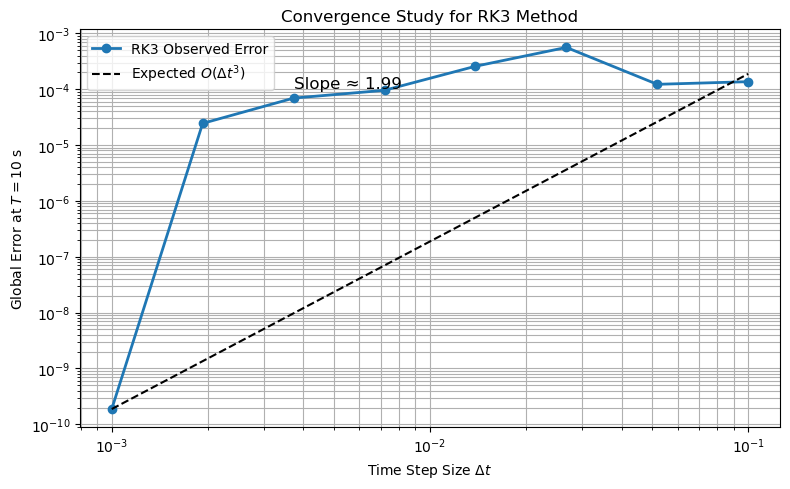

In [9]:
# Initial condition
x0 = [0.2, 0.0]             # theta(0) = 0.2 rad, theta_dot(0) = 0.0
tspan = (0, 10)             # simulate for 10 seconds
dt_vals = np.logspace(-3, -1, 8)  # 8 time step values from 0.001 to 0.1
errors = []

# Generate high-accuracy RK4 reference solution (step size = 1e-6)
t_ref, x_ref = rk4(pendulum_rhs, x0, tspan, 1e-4, args=params)
theta_ref = x_ref[-1, 0]  # final angular position for comparison

# Run RK3 for each dt and compute final-time error
for dt in dt_vals:
    t_rk3, x_rk3 = rk3(pendulum_rhs, x0, tspan, dt, args=params)
    theta_rk3 = x_rk3[-1, 0]
    errors.append(abs(theta_rk3 - theta_ref))

# Expected error curve for comparison (slope = 3)
expected_slope = 3
ref_error = errors[0]
ref_dt = dt_vals[0]
expected_errors = [ref_error * (dt / ref_dt)**expected_slope for dt in dt_vals]

# Plotting the results
plt.figure(figsize=(8, 5))
plt.loglog(dt_vals, errors, 'o-', label='RK3 Observed Error', linewidth=2)
plt.loglog(dt_vals, expected_errors, 'k--', label='Expected $O(\\Delta t^3)$', linewidth=1.5)
plt.grid(True, which='both')

# Fit line to extract slope from data
slope = np.polyfit(np.log(dt_vals), np.log(errors), 1)[0]
plt.text(dt_vals[2], errors[2]*1.5, f"Slope ≈ {slope:.2f}", fontsize=12)

# Axis labels and title
plt.xlabel('Time Step Size $\\Delta t$')
plt.ylabel('Global Error at $T = 10$ s')
plt.title('Convergence Study for RK3 Method')
plt.legend()
plt.tight_layout()
plt.show()
